Лабораторная работа № 10: **Dimension reduction** <br>
Выполнил: **Русин Ярослав, гр.6135**

In [63]:
import pandas as pd
from dask import delayed
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
---
## 0. Найти датасет
> `(желательно датасет для многоклассовой классификации, нагляднее для дальнейшей визуализации, либо дадасет из предыдущей работы с результатами кластеризации) с большим количеством вещественных признаков (от 20-ти шт.)`

## Описание данных

**Исходные данные:** https://www.kaggle.com/iamhungundji/covid19-symptoms-checker <br><br>
**Датасет с бинарными значениями заболеваний SaRS-Covid-19 и признаками протекания болезней**<br>

In [49]:
!unzip /content/drive/MyDrive/Datasets/Covid19.zip -d data

Archive:  /content/drive/MyDrive/Datasets/Covid19.zip
  inflating: data/Cleaned-Data.csv   
  inflating: data/Raw-Data.csv       


In [11]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz


In [64]:
frame = pd.read_csv("data/Cleaned-Data.csv")
LIMIT = 400
frame = frame[:LIMIT]
frame.head(15)

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,China
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,China
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,China
3,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,China
4,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,China
5,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,China
6,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,China
7,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,China
8,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,China
9,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,China


In [32]:
#sf = sf[sf[:] != '?'].iloc[:,:] #найдем все пропуски в данных и заменим их на медианный
#sf.fillna(sf.median(), inplace = True)

In [66]:
frame.shape

(400, 27)

In [67]:
frame.isna().sum()

Fever                      0
Tiredness                  0
Dry-Cough                  0
Difficulty-in-Breathing    0
Sore-Throat                0
None_Sympton               0
Pains                      0
Nasal-Congestion           0
Runny-Nose                 0
Diarrhea                   0
None_Experiencing          0
Age_0-9                    0
Age_10-19                  0
Age_20-24                  0
Age_25-59                  0
Age_60+                    0
Gender_Female              0
Gender_Male                0
Gender_Transgender         0
Severity_Mild              0
Severity_Moderate          0
Severity_None              0
Severity_Severe            0
Contact_Dont-Know          0
Contact_No                 0
Contact_Yes                0
Country                    0
dtype: int64

In [68]:
frame = frame.drop(columns='Country')

In [69]:
frame.head(3)

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0


In [70]:
temp = frame.drop(columns=['None_Sympton'])

## 1. Произвести визуализацию точек из исходного признакового пространства в 2-мерном пространстве, используя алгоритм t-SNE (sklearn.manifold.TSNE). Цвет точек пусть отражает метки классов (или номера кластеров из предыдущей работы).

In [71]:
%%time
tsne = TSNE(n_components=2, n_iter=250, n_jobs=-1)
tsne_data = tsne.fit_transform(temp)

CPU times: user 10.4 s, sys: 20.9 ms, total: 10.4 s
Wall time: 5.3 s


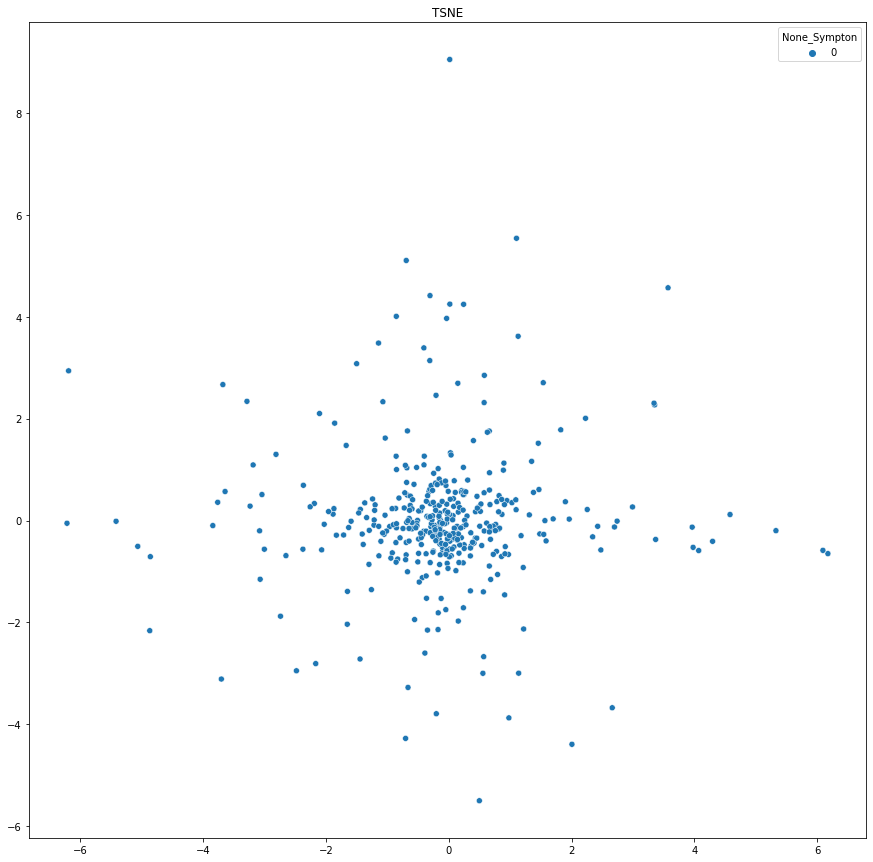

In [74]:
plt.figure(figsize=(15,15))
plt.title("TSNE")
sns.scatterplot(x=tsne_data[:,0],y=tsne_data[:,1],hue=frame['None_Sympton'])

## 2. Произвести визуализацию точек из исходного признакового пространства в 2-мерном пространстве, используя метод главных компонент (sklearn.decomposition.PCA) или Truncated SVD (sklearn.decomposition.TruncatedSVD). Цвет точек пусть отражает метки классов (или номера кластеров из предыдущей работы).

In [75]:
%%time
pca = PCA(n_components=2)
pca_data = pca.fit_transform(temp)

CPU times: user 67.3 ms, sys: 7.98 ms, total: 75.3 ms
Wall time: 42.5 ms


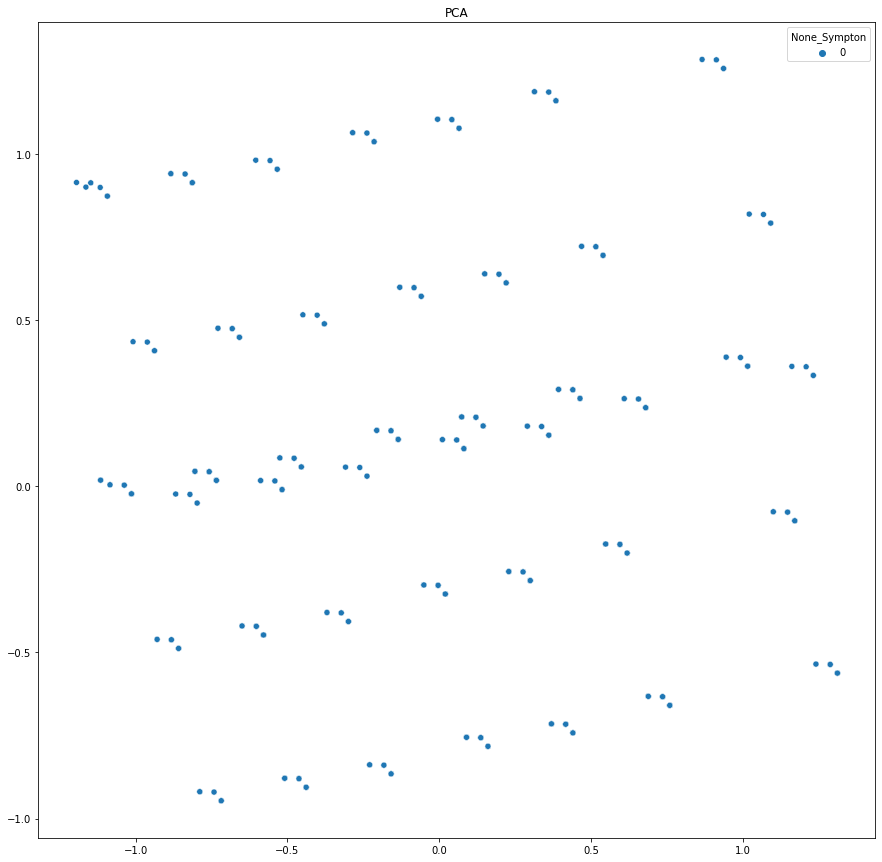

In [76]:
plt.figure(figsize=(15,15))
plt.title("PCA")
sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],hue=frame['None_Sympton'])

In [77]:
%%time
tsvd = TruncatedSVD(n_components=2,n_iter=1000)
tsvd_data = tsvd.fit_transform(temp)

CPU times: user 2.26 s, sys: 458 ms, total: 2.71 s
Wall time: 1.41 s


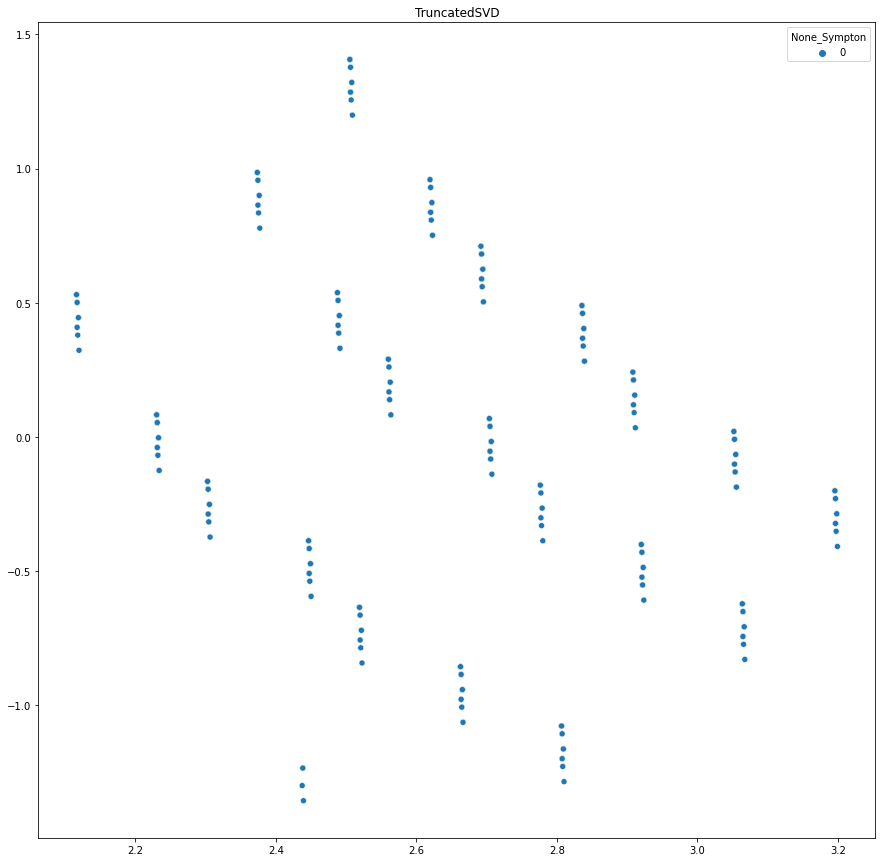

In [78]:
plt.figure(figsize=(15,15))
plt.title("TruncatedSVD")
sns.scatterplot(x=tsvd_data[:,0],y=tsvd_data[:,1],hue=frame['None_Sympton'])

## 3. На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. Чтобы оценить необходимое количество компонент, постройте график Number of components / Total explained variance. Пример построения есть в статье от ODS.

In [79]:
components_ratio = PCA().fit(temp).explained_variance_ratio_*100

In [80]:
components_ratio.shape

(25,)

Text(0, 0.5, 'Объясненный коэффициент дисперсии')

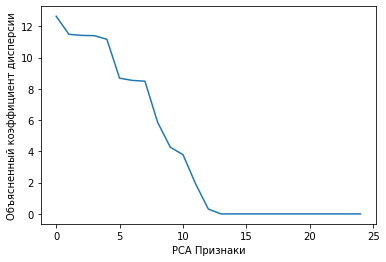

In [94]:
plt.plot(range(components_ratio.size), components_ratio)
plt.xlabel('PCA Признаки')
plt.ylabel('Объясненный коэффициент дисперсии')

Text(0, 0.5, 'Общий объясненный коэффициент дисперсии')

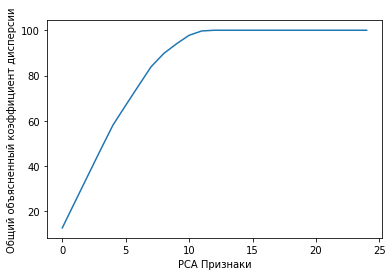

In [95]:
plt.plot(range(components_ratio.size), np.cumsum(components_ratio))
plt.xlabel('PCA Признаки')
plt.ylabel('Общий объясненный коэффициент дисперсии')

## 4. Возьмите модель машинного обучения из любой предыдущей работы (главное, чтобы в ней было минимум несколько вещественных признаков), либо постройте новую. Сравните метрики качества исходной модели и другой модели, где вещественные признаки предварительно прошли через процедуру снижения размерности. Напишите выводы.

In [83]:
estimator = RandomForestClassifier()
scaler = StandardScaler()

In [85]:
features = frame.drop(columns=['None_Sympton'])
target = frame.None_Sympton
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=13)

### Scaler  $\rightarrow$  KNN

In [86]:
%%time
basic_pipe = make_pipeline(scaler, estimator)
basic_pipe.fit(X_train, y_train)
pred = basic_pipe.predict(X_test)
print(f"score on train: {basic_pipe.score(X_train, y_train)}")
print(f"score on test: {basic_pipe.score(X_test, y_test)}")

score on train: 1.0
score on test: 1.0
CPU times: user 1.35 s, sys: 3.99 ms, total: 1.36 s
Wall time: 696 ms


### Scaler   $\rightarrow$   PCA(2)   $\rightarrow$   KNN

In [87]:
%%time
pipe = make_pipeline(scaler, PCA(n_components=2), estimator)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f"score on train: {pipe.score(X_train, y_train)}")
print(f"score on test: {pipe.score(X_test, y_test)}")

score on train: 1.0
score on test: 1.0
CPU times: user 1.35 s, sys: 6.99 ms, total: 1.35 s
Wall time: 694 ms


### Scaler   $\rightarrow$   PCA(4)   $\rightarrow$   KNN

In [88]:
%%time
pipe = make_pipeline(scaler, PCA(n_components=4), estimator)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f"score on train: {pipe.score(X_train, y_train)}")
print(f"score on test: {pipe.score(X_test, y_test)}")

score on train: 1.0
score on test: 1.0
CPU times: user 1.36 s, sys: 987 µs, total: 1.36 s
Wall time: 712 ms


### Scaler   $\rightarrow$   PCA(6)   $\rightarrow$   KNN

In [89]:
%%time
pipe = make_pipeline(scaler, PCA(n_components=6), estimator)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f"score on train: {pipe.score(X_train, y_train)}")
print(f"score on test: {pipe.score(X_test, y_test)}")

score on train: 1.0
score on test: 1.0
CPU times: user 1.47 s, sys: 7.99 ms, total: 1.47 s
Wall time: 765 ms


### Scaler   $\rightarrow$   PCA(8)   $\rightarrow$   KNN

In [90]:
%%time
pipe = make_pipeline(scaler, PCA(n_components=8), estimator)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f"score on train: {pipe.score(X_train, y_train)}")
print(f"score on test: {pipe.score(X_test, y_test)}")

score on train: 1.0
score on test: 1.0
CPU times: user 1.51 s, sys: 4.98 ms, total: 1.51 s
Wall time: 791 ms


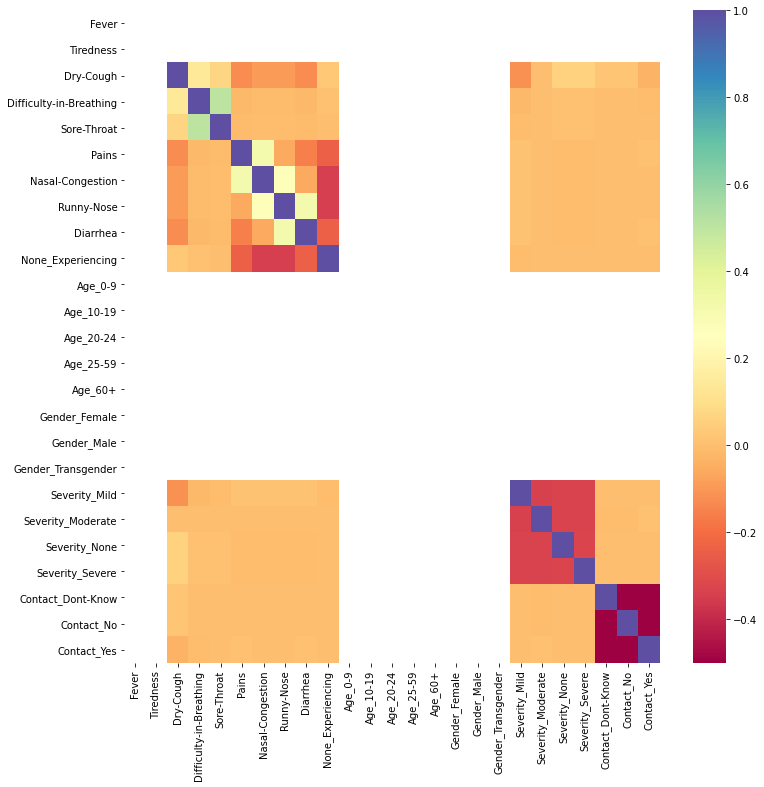

In [96]:
plt.figure(figsize=(12, 12))
sns.heatmap(temp.corr(), cmap= 'Spectral')

**Полученные значения вполне логичные. Однако из-за большого количества строк в оригинальном датасете (316 000) реализация программы обещала быть невероятно долгой, некоторые вычисления занимали больше 20 минут. Возможно был выбран неправильно набор данных мной. Но отдельная короткая выборка в 400 строк дала свои положительные результаты. 
За график с вырезанными значениями прошу прощения :)**